In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pickle
from collections import deque

import pickle
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


In [2]:
import os
import pickle


def run_simulation(IS_INDUCED, L=20, N=150, fraction_core=0.10, T=5, p=0.01, steps=500,
                   J_AA=-10, J_BB=-100):
    # Assign parameters
    N_B = int(N * fraction_core)   # number of B-type
    N_A = N - N_B
    
    # Initialize grid
    grid = -1 * np.ones((L, L), dtype=int)
    
    # Place cells in a circular region
    center = (L//2, L//2)
    positions = [(x, y) for x in range(L) for y in range(L)]
    positions.sort(key=lambda pos: (pos[0]-center[0])**2+(pos[1]-center[1])**2)
    selected_positions = positions[:N]
    np.random.shuffle(selected_positions)
    for i, (x, y) in enumerate(selected_positions):
        if i < N_A:
            grid[x, y] = 0 # A
        else:
            if IS_INDUCED:
                grid[x, y] = 1 # B (low)
            else:
                grid[x, y] = 2 # B (high)
    
    # Helper functions
    
    # could be either 4 or 8 neighbors. now chose 8
    def get_neighbors(x, y):
        nbrs = []
        # for dx, dy in [(1,0),(-1,0),(0,1),(0,-1)]:
        for dx, dy in [ (1,0),(-1,0),(0,1),(0,-1),
                        (-1,-1),(-1,1),(1,-1),(1,1)]:
            nx, ny = x+dx, y+dy
            if 0 <= nx < L and 0 <= ny < L:
                nbrs.append((nx, ny))
        return nbrs

    # here cores are only B_HIGH cells
    def count_cores(grid):
        visited = np.zeros_like(grid, dtype=bool)
        # directions = [(1,0),(-1,0),(0,1),(0,-1)]
        cores = 0
        L = grid.shape[0]

        for i in range(L):
            for j in range(L):
                if (grid[i,j] == 2) and not visited[i,j]:
                    # BFS/DFS to find connected component
                    cores += 1
                    queue = deque([(i,j)])
                    visited[i,j] = True
                    while queue:
                        x,y = queue.popleft()
                        for nx,ny in get_neighbors(x,y):
                        # for dx,dy in directions:
                        #     nx, ny = x+dx, y+dy
                            if 0<=nx<L and 0<=ny<L and not visited[nx,ny]:
                                if grid[nx,ny] == 2:
                                    visited[nx,ny] = True
                                    queue.append((nx,ny))
        return cores

    def local_energy(x, y):
        ctype = grid[x,y]
        if ctype == -1:
            return 0
        nbrs = get_neighbors(x,y)
        E = 0
        for nx, ny in nbrs:
            ntype = grid[nx, ny]
            if ntype == -1:
                continue
            # For simplicity, assume J_AB = J_AA as in the original code snippet
            if ctype==2 and ntype==2:
                E += J_BB
            else:
                E += J_AA
        return E
    
    def energy_difference_swap(x1, y1, x2, y2):
        E_before = local_energy(x1,y1) + local_energy(x2,y2)
        c1, c2 = grid[x1,y1], grid[x2,y2]
        grid[x1,y1], grid[x2,y2] = c2, c1
        E_after = local_energy(x1,y1) + local_energy(x2,y2)
        grid[x1,y1], grid[x2,y2] = c1, c2
        return E_after - E_before
    
    def attempt_state_transition(x, y):
        if np.random.rand() < p:
            if grid[x,y] == 1:
                nbrs = get_neighbors(x,y)
                A_count = sum(grid[nx,ny] == 0 for nx,ny in nbrs)
                if A_count >= 3:
                    grid[x,y] = 2 # B_low -> B_high
    
    def attempt_swap(x, y):
        nbrs = get_neighbors(x,y)
        ctype = grid[x,y]

        valid_nbrs = [nbr for nbr in nbrs if grid[nbr]!=ctype]  

        if len(valid_nbrs)==0: return        
        nx, ny = valid_nbrs[np.random.randint(len(valid_nbrs))]
        dE = energy_difference_swap(x,y,nx,ny)
        if dE <= 0:
            grid[x, y], grid[nx, ny] = grid[nx, ny], grid[x, y]
        else:
            if np.random.rand() < np.exp(-dE/T):
                grid[x, y], grid[nx, ny] = grid[nx, ny], grid[x, y]
    
    # Simulation loop
    grids_over_time = []
    cores_over_time = []
    for step_i in range(steps+1):
        # Record state
        grids_over_time.append(grid.copy())
        cores_over_time.append(count_cores(grid))
        
        if step_i == steps:
            break

        for _ in range(N):
            occ_positions = np.argwhere(grid != -1)
            x, y = occ_positions[np.random.randint(len(occ_positions))]
            attempt_state_transition(x, y)
            attempt_swap(x, y)
    
    return {"IS_INDUCED": IS_INDUCED,
            "grid_history": grids_over_time,
            "cores_history": cores_over_time,
            "parameters": {"L": L, "N": N, "fraction_core": fraction_core,
                           "T": T, "p": p, "steps": steps, "J_AA": J_AA, "J_BB": J_BB}}

###############################
# Run multiple simulations and save results
###############################
if not os.path.exists("simulation_results.pkl"):
    all_results_induced = []
    all_results_constitutive = []
    n_reps = 100

    for i in range(n_reps):
        res_induced = run_simulation(IS_INDUCED=True)
        all_results_induced.append(res_induced)
        res_const = run_simulation(IS_INDUCED=False)
        all_results_constitutive.append(res_const)

    # Save all results
    with open("simulation_results.pkl", "wb") as f:
        pickle.dump({"induced": all_results_induced, "constitutive": all_results_constitutive}, f)
else:
    print("Loading existing simulation results...")
    with open("simulation_results.pkl", "rb") as f:
        data = pickle.load(f)

# Access the data
all_results_induced = data["induced"]
all_results_constitutive = data["constitutive"]


Loading existing simulation results...


median:1.0, mean:1.4,std: 0.4898979485566357,1_core_count:60
median:2.0, mean:2.36,std: 0.7002856560004638,1_core_count:11


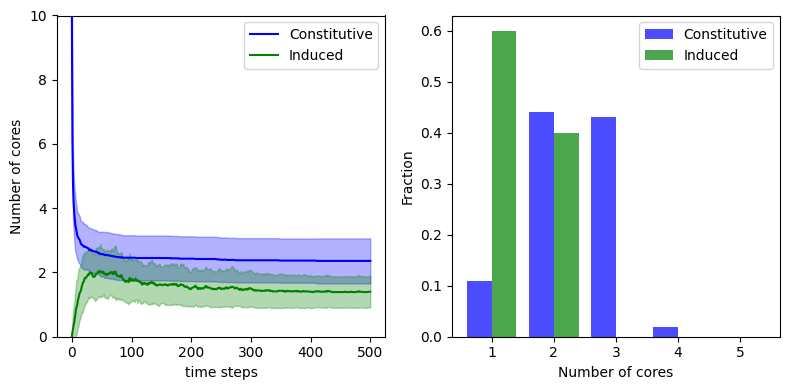

In [3]:

###############################
# Analysis and plotting
###############################

# Compute average cores over time for induced and constitutive
induced_cores_matrix = np.array([r["cores_history"] for r in all_results_induced])
constitutive_cores_matrix = np.array([r["cores_history"] for r in all_results_constitutive])

induced_mean = induced_cores_matrix.mean(axis=0)
induced_std = induced_cores_matrix.std(axis=0)
constitutive_mean = constitutive_cores_matrix.mean(axis=0)
constitutive_std = constitutive_cores_matrix.std(axis=0)

# Final distribution of number of cores
final_induced_cores = induced_cores_matrix[:,-1]
final_constitutive_cores = constitutive_cores_matrix[:,-1]


# print statistics
for res in [final_induced_cores,final_constitutive_cores]:
    print(f'median:{np.median(res)}, mean:{np.mean(res)},std: {np.std(res)},1_core_count:{sum(res==1)}')


fig, (ax2, ax1) = plt.subplots(1,2, figsize=(8,4))

# Bar plot at final step
bins = np.arange(1, 7)  # Creating bins from 1 to 6 to represent core counts

# Plotting histograms with normalization to make fractions sum to 1
bar_width = 0.4
ax1.bar(np.arange(1, 6) - bar_width / 2, np.histogram(final_constitutive_cores, bins=bins, density=True)[0], 
        width=bar_width, alpha=0.7, label='Constitutive', color='blue')
ax1.bar(np.arange(1, 6) + bar_width / 2, np.histogram(final_induced_cores, bins=bins, density=True)[0], 
        width=bar_width, alpha=0.7, label='Induced', color='green')


ax1.set_xlabel('Number of cores')
ax1.set_ylabel('Fraction')
ax1.legend()

# Time series with shaded error
x = np.arange(len(induced_mean))

ax2.plot(x, constitutive_mean, color='blue', label='Constitutive')
ax2.fill_between(x, constitutive_mean-constitutive_std, constitutive_mean+constitutive_std, color='blue', alpha=0.3)
ax2.plot(x, induced_mean, color='green', label='Induced')
ax2.fill_between(x, induced_mean-induced_std, induced_mean+induced_std, color='green', alpha=0.3)
ax2.set_xlabel('time steps')
ax2.set_ylabel('Number of cores')
ax2.set_ylim(0,10)
ax2.legend()

plt.tight_layout()
plt.show()


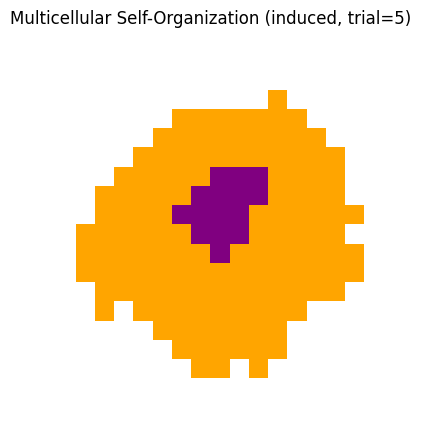

In [ ]:


import pickle
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
from IPython.display import HTML

def visualize_simulation(experiment_type='induced', trial=0, pkl_file='simulation_results.pkl'):
    # Load results from pkl
    with open(pkl_file, "rb") as f:
        all_results = pickle.load(f)
    
    # Select the desired simulation data

    if experiment_type not in all_results:
        raise ValueError("experiment_type should be 'induced' or 'constitutive'")
    if trial < 0 or trial >= len(all_results[experiment_type]):
        raise ValueError("Invalid trial number")
        
    res = all_results[experiment_type][trial]
    grid_history = res['grid_history']

    # Define custom colormap
    colors = ['white', 'orange', 'gray', 'purple']
    cmap = ListedColormap(colors)

    # Set up the figure and initial image
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(grid_history[0], cmap=cmap, vmin=-1, vmax=2)
    ax.set_title(f'Multicellular Self-Organization ({experiment_type}, trial={trial})')
    ax.set_axis_off()

    # Update function for FuncAnimation
    def update(frame):
        im.set_data(grid_history[frame])
        return [im]

    # Create animation
    anim = FuncAnimation(fig, update, frames=len(grid_history), interval=200, blit=True, repeat=False)
    return HTML(anim.to_jshtml())

visualize_simulation('induced', trial=5)


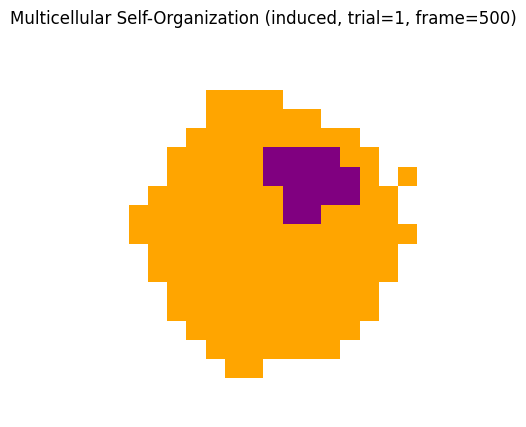

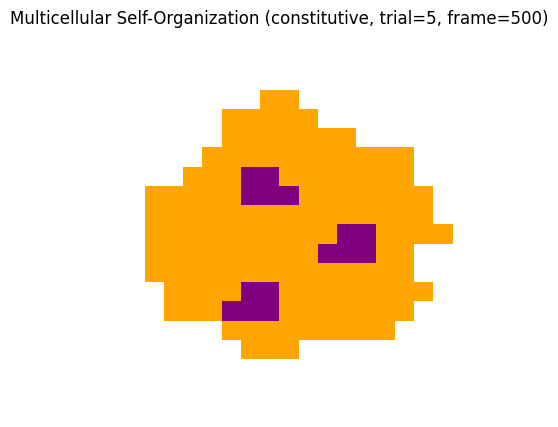

In [ ]:
def show_snapshot(experiment_type='induced', trial=0, pkl_file='simulation_results.pkl',frame=0):
    # Load results from pkl
    with open(pkl_file, "rb") as f:
        all_results = pickle.load(f)
    
    # Select the desired simulation data

    if experiment_type not in all_results:
        raise ValueError("experiment_type should be 'induced' or 'constitutive'")
    if trial < 0 or trial >= len(all_results[experiment_type]):
        raise ValueError("Invalid trial number")
        
    res = all_results[experiment_type][trial]
    grid_history = res['grid_history']

    # Define custom colormap
    colors = ['white', 'orange', 'gray', 'purple']
    cmap = ListedColormap(colors)

    # Set up the figure and initial image
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(grid_history[frame], cmap=cmap, vmin=-1, vmax=2)
    ax.set_title(f'Multicellular Self-Organization ({experiment_type}, trial={trial}, frame={frame})')
    ax.set_axis_off()
    return
frame  = 500
show_snapshot('induced', trial=1,frame=frame)
show_snapshot('constitutive', trial=5,frame=frame)